In [ ]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell as described in Figure (2)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """
    
    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    ### START CODE HERE ### (≈2 lines)
    # compute next activation state using the formula given above
    a_next = np.tanh(np.dot(Wax, xt) + np.dot(Waa, a_prev) + ba)
    # compute output of the current cell using the formula given above
    yt_pred = softmax(np.dot(Wya, a_next) + by)
    ### END CODE HERE ###
    
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache
    

def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """
    
    # Initialize "caches" which will contain the list of all caches
    caches = []
    
    # Retrieve dimensions from shapes of x and parameters["Wya"]
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    ### START CODE HERE ###
    
    # initialize "a" and "y_pred" with zeros (≈2 lines)
    a = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    
    # Initialize a_next (≈1 line)
    a_next = a0
    
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, compute the prediction, get the cache (≈1 line)
        a_next, yt_pred, cache = rnn_cell_forward(x[:,:,t], a_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:,:,t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y_pred[:,:,t] = yt_pred
        # Append "cache" to "caches" (≈1 line)
        caches.append(cache)
    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)
    
    return a, y_pred, caches

# LSTM Network

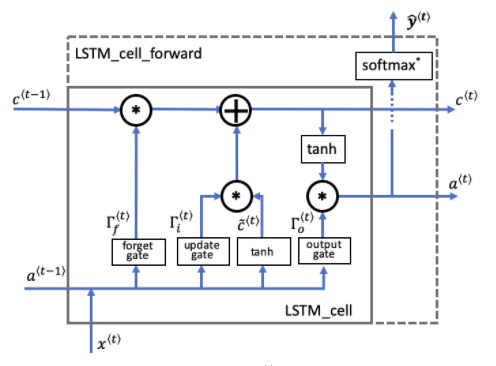

In [ ]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wi = parameters["Wi"] # update gate weight (notice the variable name)
    bi = parameters["bi"] # (notice the variable name)
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]
    Wy = parameters["Wy"] # prediction weight
    by = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    ### START CODE HERE ###
    # Concatenate a_prev and xt (≈1 line)
    concat = np.concatenate((a_prev, xt), axis=0)

    # Compute values for ft, it, cct, c_next, ot, a_next using the formulas given figure (4) (≈6 lines)
    ft = sigmoid(np.dot(Wf, concat) + bf)
    it = sigmoid(np.dot(Wi, concat) + bi)
    cct = np.tanh(np.dot(Wc, concat) + bc)
    c_next = ft * c_prev + it * cct
    ot = sigmoid(np.dot(Wo, concat) + bo)
    a_next = ot * np.tanh(c_next)
    
    # Compute prediction of the LSTM cell (≈1 line)
    yt_pred = softmax(np.dot(Wy, a_next) + by)
    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [ ]:
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (4).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []
    
    ### START CODE HERE ###
    Wy = parameters['Wy'] # saving parameters['Wy'] in a local variable in case students use Wy instead of parameters['Wy']
    # Retrieve dimensions from shapes of x and parameters['Wy'] (≈2 lines)
    n_x, m, T_x = x.shape
    n_y, n_a = parameters['Wy'].shape
    
    # initialize "a", "c" and "y" with zeros (≈3 lines)
    a = np.zeros([n_a, m, T_x])
    c = np.zeros([n_a, m, T_x])
    y = np.zeros([n_y, m, T_x])
    
    # Initialize a_next and c_next (≈2 lines)
    a_next = a0
    c_next = np.zeros([n_a, m])
    
    # loop over all time-steps
    for t in range(T_x):
        # Get the 2D slice 'xt' from the 3D input 'x' at time step 't'
        xt = x[:,:,t]
        # Update next hidden state, next memory state, compute the prediction, get the cache (≈1 line)
        a_next, c_next, yt, cache = lstm_cell_forward(x[:,:,t], a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:,:,t] = a_next
        # Save the value of the next cell state (≈1 line)
        c[:,:,t]  = c_next
        # Save the value of the prediction in y (≈1 line)
        y[:,:,t] = yt
        # Append the cache into caches (≈1 line)
        caches.append(cache)
        
    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches